In [30]:
from google.colab import files
uploaded = files.upload()

Saving end to end


In [ ]:
!pip install pyyaml h5py

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split, GridSearchCV
import os as os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import warnings
from sklearn.preprocessing import StandardScaler
import scipy.io as spio
from scipy import stats, signal
from sklearn import preprocessing
from keras.layers import Dense, Input, LSTM, RepeatVector,TimeDistributed, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, TensorBoard,ModelCheckpoint
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
from keras.utils import plot_model
import seaborn as sns
import pywt
from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**1. Этап обработки сигналов**
<br>Данный этап призван удалить из исходных сигналов шумы различных частот. Для этого используются фильтр Баттерворта низких частот, высокочастотный фильтр на основе быстрого вейвлет-преобразования, а также полосовой фильтр Баттерворта.


In [3]:
#information about mother wavelet Daubechie4
mother_wavelet=pywt.Wavelet('db4')

def butter_lowpass(y, cutoff, sample_rate, order):
    nyq_freq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    rec=signal.lfilter(b,a,y)
    return rec

def highpassfilter(signal, mother_wavelet):
    coeffs = pywt.wavedec(signal, mother_wavelet, mode="per")
    coeffs[1:]=(np.array([0.0 for j in range(len(i))]) for i in coeffs[1:])
    reconstructed_signal = pywt.waverec(coeffs, mother_wavelet, mode="per" )
    return reconstructed_signal

def butter_bandpass(y, lowcut, highcut, sample_rate, order):  
    nyq_freq = 0.5*sample_rate
    low = lowcut / nyq_freq
    high = highcut / nyq_freq
    b, a = signal.butter(order, [low, high], btype='band')
    rec=signal.lfilter(b,a,y)
    return rec

Основной проблемой задач обнаружения аномалий является недостаток данных с примерами аномального класса. Поэтому часто приходится применять искусственный синтез таких данных. В данной работе были использованы упрощенные методы с использованием следующих трех классов:

In [17]:
class BaseAnomaly:
    def __init__(self, timeseries, start, **kwargs):
        self.template = timeseries
        self.start_time=start
        self.params=kwargs
    
class ExtremeAnomaly(BaseAnomaly):
    def __init__(self, timeseries, start, count):        
        super().__init__(timeseries, start, count=count)
    def insert(self):        
        for i in range(self.params['count']):
            point_time=np.random.randint(self.start_time,len(self.template))
            print(point_time)
            sign=np.random.choice([-1,1])
            if sign==-1:
              point=np.random.uniform(self.template.mean(),max(self.template))
            else:
              point=np.random.uniform(min(self.template),self.template.mean())
            self.template[point_time]=point 
            print(point)
            eps=10
            a=(self.template[point_time]-self.template[point_time-eps])/(eps)
            b=self.template[point_time]-a*point_time
            for j in range(eps,-1,-1):
                self.template[point_time-j]=a*(point_time-j)+b

class NoiseAnomaly(BaseAnomaly):
    def __init__(self, timeseries, start, count, mu, sigma):        
        super().__init__(timeseries, start, mu=mu, sigma=sigma, count=count)
    def insert(self):        
        for i in range(self.params['count']):
            start_time=np.random.randint(self.start_time,len(self.template)-300)
            print(start_time,'2')
            end_time=start_time+np.random.randint(150,300)
            for j in range(end_time-start_time):        
                self.template[start_time+j]+=np.random.normal(self.params['mu'],self.params['sigma'])

class DispersionAnomaly(BaseAnomaly):
    def __init__(self, timeseries, start, count, mu, sigma):        
        super().__init__(timeseries, start, mu=mu, sigma=sigma, count=count)
    def insert(self):        
        for i in range(self.params['count']):
            start_time=np.random.randint(self.start_time,len(self.template)-200)
            print(start_time,'3')
            end_time=start_time+np.random.randint(100,200)
            appr_signal=highpassfilter(self.template,mother_wavelet)
            detail_signal=self.template-appr_signal
            #alpha=np.random.uniform(2,3)
            alpha=5
            for j in range(end_time-start_time):        
                self.template[start_time+j]=alpha*appr_signal[start_time+j]+detail_signal[start_time+j]


Загрузка и визуализация данных:

In [37]:
#Dataset reading and vizualization
data=pd.read_csv('challenge3.csv',sep=',',usecols=['Elapsed time','ECG'])
data['Elapsed time']=[float(x) for x in data['Elapsed time']]
#data['Elapsed time']=[i-40 if int(i)>=40 else i+20 for i in data['Elapsed time']]
data['ECG']=[-x for x in data['ECG']]
data

,Elapsed time,ECG
0,0.000,0.185
1,0.005,0.294
2,0.010,0.234
3,0.015,0.094
4,0.020,0.216
...,...,...
1995,9.975,0.209
1996,9.980,0.169
1997,9.985,-0.002
1998,9.990,0.108


Визуализация спектра исходного сигнала:

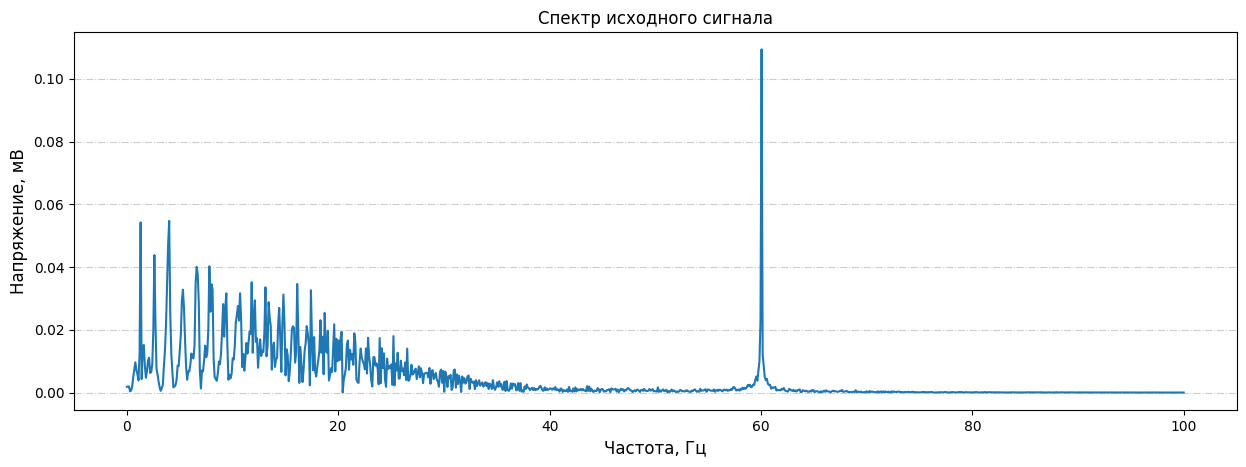

In [38]:
signalf=data['ECG'].values.reshape(1,-1)
spectrum=scipy.fft.fft(signalf[0])
N=data.shape[0]
fig=plt.figure(figsize=(15,5),dpi=100)
axes=fig.add_subplot(111)
axes.plot(np.linspace(0.0, 200/2, N//2), 2/N *np.abs(spectrum[0:N//2]))
axes.set_title('Спектр исходного сигнала')
axes.set_ylabel('Напряжение, мВ', fontsize=12)
axes.set_xlabel('Частота, Гц', fontsize=12)
axes.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')

Добавление искусственно синтезированных аномалий к исходному датасету:

In [23]:
start=800
extreme_anomaly=ExtremeAnomaly(data.ECG,start,count=1)
extreme_anomaly.insert()

noise_anomaly=NoiseAnomaly(data.ECG,start,count=1, mu=0.0, sigma=1.0)
#noise_anomaly.insert()

disp_anomaly=DispersionAnomaly(data.ECG,start,count=1, mu=0.0, sigma=1.0)
disp_anomaly.insert()

1262
1.1606782025615312
1226 3


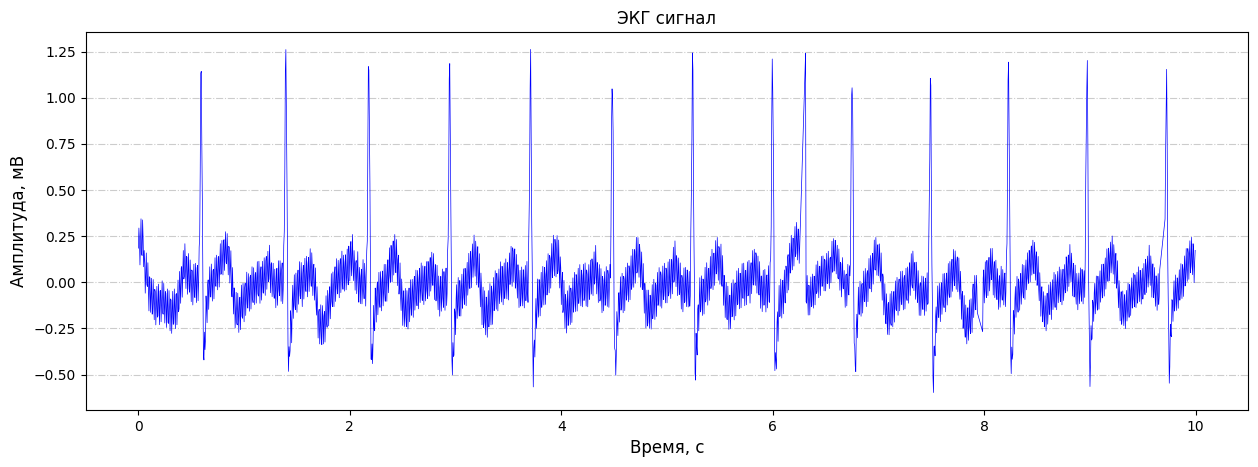

In [24]:
fig=plt.figure(figsize=(15,5),dpi=100)
axes=fig.add_subplot(111)
axes.plot(data['Elapsed time'],data['ECG'],'blue',linewidth=0.5,antialiased=True)
axes.set_title('ЭКГ сигнал')
axes.set_ylabel('Амплитуда, мВ',fontsize=12)
axes.set_xlabel('Время, с',fontsize=12)
#axes.set_ylim(-1,1.5)
axes.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')

Демонстрация последовательного удаления высокочастотного и низкочастотного шума с применением фильтра Баттерворта нижних частот и дискретного вейвлет преобразования соответственно:

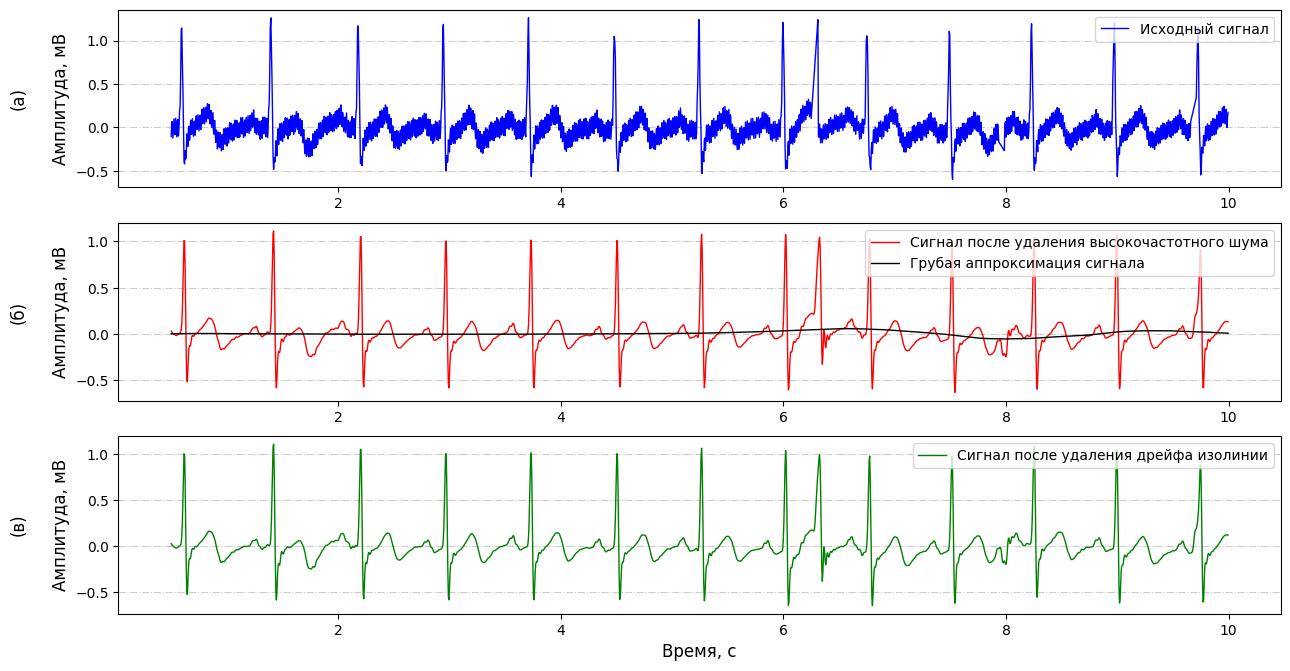

In [25]:
rec_low=butter_lowpass(data.ECG, 35, 200, 8)
rec_high=highpassfilter(rec_low,mother_wavelet)
rec=rec_low-rec_high
#print(rec_low.shape)
window_size=100
rolling_mean=pd.Series(rec_low).rolling(window=window_size).mean()
#print(rolling_mean.shape)
#rec=rec_low[window_size:]-rolling_mean[window_size:]


fig=plt.figure(figsize=(15,8),dpi=100)
axes=fig.add_subplot(311)
axes.plot(data['Elapsed time'][window_size:],data['ECG'][window_size:],'blue',linewidth=1, label='Исходный сигнал')
axes.set_ylabel('(а)\n\nАмплитуда, мВ', fontsize=12)
axes.legend(loc=1)
#axes.set_ylim(-2,2)
axes.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')

axes=fig.add_subplot(312)
axes.plot(data['Elapsed time'][window_size:],rec_low[window_size:],'red',linewidth=1,label='Сигнал после удаления высокочастотного шума')
axes.plot(data['Elapsed time'][window_size:],rec_high[window_size:],'black',linewidth=1, label='Грубая аппроксимация сигнала')
axes.set_ylabel('(б)\n\nАмплитуда, мВ', fontsize=12)
axes.legend(loc=1)
axes.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')

axes=fig.add_subplot(313)
axes.plot(data['Elapsed time'][window_size:], rec[window_size:],'green',linewidth=1,label='Сигнал после удаления дрейфа изолинии')
axes.set_ylabel('(в)\n\nАмплитуда, мВ', fontsize=12)
axes.set_xlabel('Время, с', fontsize=12)
#axes.set_ylim(-2,2)
axes.legend(loc=1)
axes.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')
plt.show()


**2. Этап обнаружения аномалий**
<br>Разбиение выборки на обучающую и тестовую подвыборки:

In [26]:
rec=rec[window_size:]
data=data[window_size:]

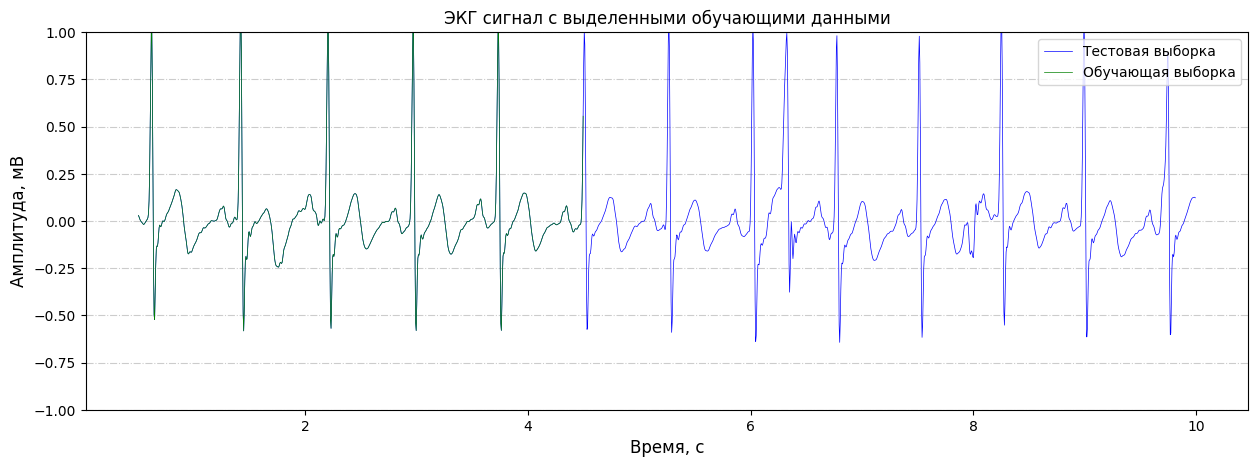

In [27]:
#rec=data.ECG.values
start=0
end=800
fig=plt.figure(figsize=(15,5),dpi=100)
axes=fig.add_subplot(111)
axes.plot(data['Elapsed time'],rec,'blue',linewidth=0.5,antialiased=True, label='Тестовая выборка')
axes.plot(data['Elapsed time'][start:end],rec[start:end],'green',linewidth=0.5,antialiased=True, label='Обучающая выборка')
axes.set_title('ЭКГ сигнал с выделенными обучающими данными')
axes.set_ylim(-1,1)
axes.set_ylabel('Амплитуда, мВ', fontsize=12)
axes.set_xlabel('Время, с', fontsize=12)
axes.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')
axes.legend(loc=1)

Преобразование данных для подачи на вход в LSTM-сеть:

In [28]:
def sliding_window(Xdata,window_size,sliding_step):
    X_in=[]
    i=0
    while i<len(Xdata)-window_size:
        X_in.append(Xdata[i:i+window_size])
        i+=sliding_step
    return np.array(X_in)
d=rec[start:end]
#d=rec
x_train,x_test=train_test_split(d,test_size=0.375,shuffle=False)
#x_train,x_test=train_test_split(d,test_size=0.6,shuffle=False)
scaler=preprocessing.StandardScaler()
x_train=scaler.fit_transform(x_train.reshape(-1,1))
x_test=scaler.fit_transform(x_test.reshape(-1,1))
window_size=50
sliding_step=1
print(x_train.shape)
x_train=sliding_window(x_train,window_size,sliding_step)
x_test=sliding_window(x_test,window_size,sliding_step)
print('Training data shape:',x_train.shape)
print('Testing data shape:',x_test.shape)

(500, 1)
Training data shape: (450, 50, 1)
Testing data shape: (250, 50, 1)


LSTM-autoencoder:

In [29]:
#LSTM-autoencoder model
lstm_autoencoder = Sequential()
lstm_autoencoder.add(LSTM(64, activation='tanh', input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='tanh', return_sequences=False))
lstm_autoencoder.add(Dropout(0.2))
lstm_autoencoder.add(RepeatVector(x_train.shape[1]))
lstm_autoencoder.add(LSTM(64, activation='tanh', return_sequences=True))
lstm_autoencoder.add(Dropout(0.2))
lstm_autoencoder.add(LSTM(64, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(x_train.shape[2])))
lstm_autoencoder.compile(optimizer='adam',loss='mean_squared_error')
lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 64)            3

Обучение нейронной сети:

In [ ]:
#training LSTM-autoencoder model
LSTM_AE=lstm_autoencoder.fit(x_train, x_train, epochs=100, batch_size=10, shuffle=True, 
                        validation_data=(x_test, x_test))

Train on 450 samples, validate on 250 samples
Epoch 1/100
450/450 [==============================] - 7s 15ms/step - loss: 0.9999 - val_loss: 0.9328
Epoch 2/100
450/450 [==============================] - 5s 11ms/step - loss: 0.8707 - val_loss: 0.8815
Epoch 3/100
450/450 [==============================] - 5s 11ms/step - loss: 0.8258 - val_loss: 0.6932
Epoch 4/100
450/450 [==============================] - 5s 11ms/step - loss: 0.6963 - val_loss: 0.5673
Epoch 5/100
450/450 [==============================] - 5s 11ms/step - loss: 0.7418 - val_loss: 0.8789
Epoch 6/100
450/450 [==============================] - 5s 11ms/step - loss: 0.7017 - val_loss: 0.5852
Epoch 7/100
450/450 [==============================] - 5s 11ms/step - loss: 0.6004 - val_loss: 0.4281
Epoch 8/100
450/450 [==============================] - 5s 11ms/step - loss: 0.6071 - val_loss: 0.6386
Epoch 9/100
450/450 [==============================] - 5s 11ms/step - loss: 0.5791 - val_loss: 0.3595
Epoch 10/100
450/450 [==============

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
#lstm_autoencoder.save('saved_model/final')

In [31]:
lstm_autoencoder = load_model('final')

Распределение функции потерь:

(22470,)


(0.0, 1.0)

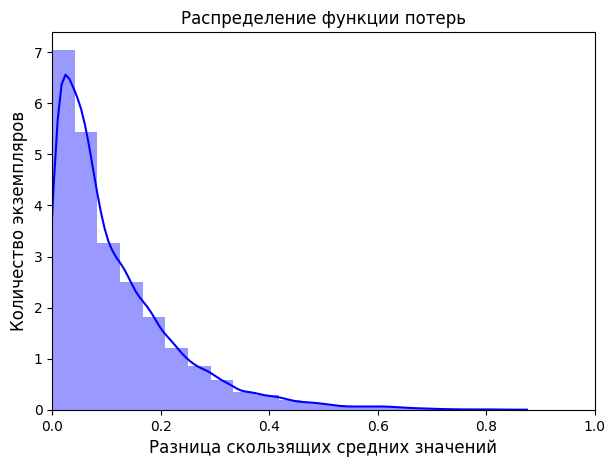

In [32]:
x_pred=lstm_autoencoder.predict(x_train)
x_pred=x_pred.reshape(1,-1)[0]                  
x_train=x_train.reshape(1,-1)[0]
window_size=30
rolling_mean1=pd.Series(x_train).rolling(window=window_size).mean()
rolling_mean2=pd.Series(x_pred).rolling(window=window_size).mean()
train_loss=rolling_mean1[window_size:]-rolling_mean2[window_size:]
#train_loss=x_pred-x_train
scored_loss=np.abs(train_loss)
print(scored_loss.shape)
plt.figure(figsize=(7,5), dpi=100)
sns.distplot(scored_loss, bins=20, kde=True, color='blue')
plt.xlabel('Разница скользящих средних значений', fontsize=12)
plt.ylabel('Количество экземпляров', fontsize=12)
plt.title('Распределение функции потерь', fontsize=12)
plt.xlim([0.0,1.0])

По распределению функции потерь, полученной в ходе обучения сети, было выбрано пороговое значение=0.6.

Результирующий график с отмеченными аномалиями:

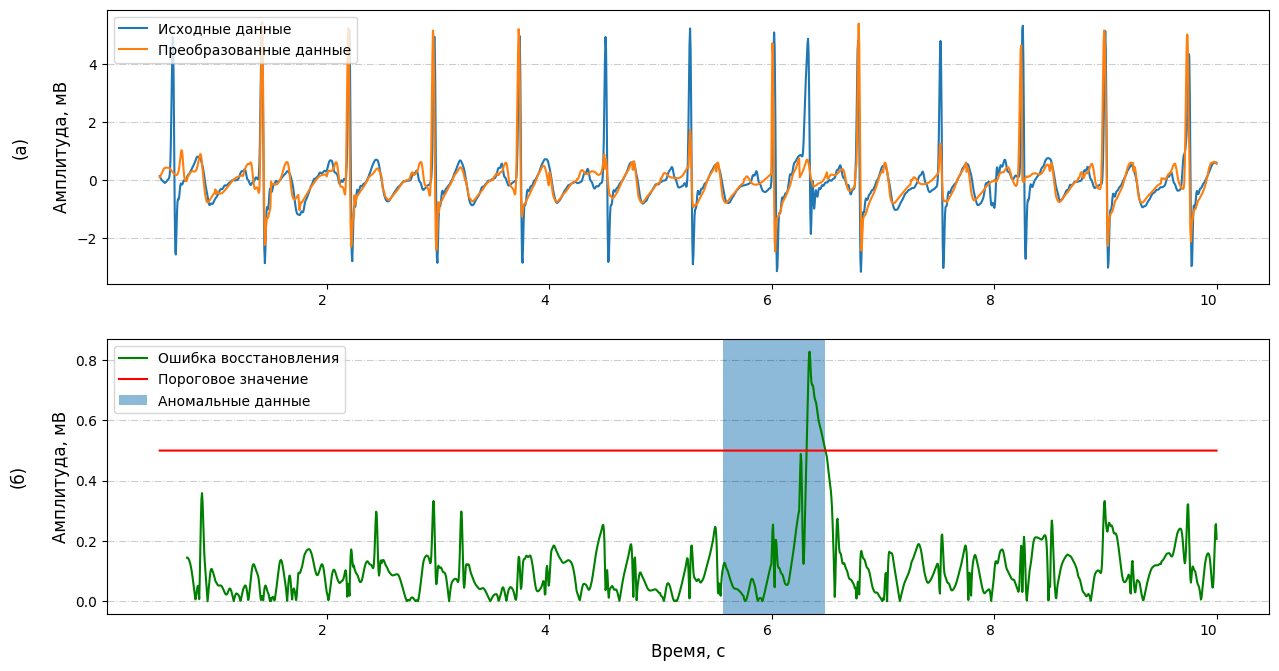

In [35]:
window_size=50
y_original=rec
y_original=scaler.fit_transform(y_original.reshape(-1,1))
y_original=np.reshape(y_original, (-1, window_size, y_original.shape[1]))
pred_val=lstm_autoencoder.predict(y_original)
y_original=np.reshape(y_original, (1, -1))[0]
pred_val=np.reshape(pred_val, (1, -1))[0]
window_size=50
rolling_mean1=pd.Series(y_original).rolling(window=window_size).mean()

#y_original1=y_original[window_size:]-rolling_mean[window_size:]
rolling_mean2=pd.Series(pred_val).rolling(window=window_size).mean()
#pred_val1=pred_val[window_size:]-rolling_mean[window_size:]
rec_error=rolling_mean1-rolling_mean2
threshold=0.5
threshold_plot=[threshold for i in range(rec.shape[0])]
places=np.where(np.fabs(rec_error)>threshold)



places_list=[]
temp=[]
if len(places)>1:
  for i in range(len(places[0])-1):
    if places[0][i+1]-places[0][i]==1:
      temp.append(places[0][i])
    else:
      places_list.append(temp.copy())
      temp.clear()
  temp.append(places[0][-1])
  places_list.append(temp.copy())
  temp.clear()
elif len(places)==1:
  places_list.append(places)


figprops = dict(figsize=(15,8), dpi=100)
plt.figure(**figprops)
ax1=plt.subplot(2,1,1)
plt.plot(data['Elapsed time'],y_original)
plt.plot(data['Elapsed time'],pred_val)
#plt.plot(data['Elapsed time'],pred_val)
plt.ylabel('(a)\n\nАмплитуда, мВ', fontsize=12)
ax1.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')
plt.xticks(rotation=0, ha='right')
plt.legend(['Исходные данные','Преобразованные данные'],loc=2)

ax1=plt.subplot(2,1,2)
plt.plot(data['Elapsed time'],np.fabs(rec_error), 'green', label='Ошибка восстановления')
plt.plot(data['Elapsed time'],threshold_plot, 'red', label='Пороговое значение')

if len(places_list[0])!=0:
  for i in range(len(places_list[0])):
    ind1=places_list[0][i][0]
    ind2=places_list[0][i][-1]
    if i==0:
      ax1.axvspan(data['Elapsed time'][ind1]-50/200, data['Elapsed time'][ind2]+100/200, ymin=0, alpha=0.5, label='Аномальные данные')
    else:
      ax1.axvspan(data['Elapsed time'][ind1]-50/200, data['Elapsed time'][ind2]+100/200, ymin=0, alpha=0.5)

plt.xlabel('Время, c', fontsize=12)
plt.ylabel('(б)\n\nАмплитуда, мВ', fontsize=12)
ax1.grid(b=None, which='major', axis='y', alpha=0.2, antialiased=True, c='k', linestyle='-.')
plt.xticks(rotation=0, ha='right')
plt.legend(loc=2)

In [36]:
#%% Plotting performance of lstm-autoencoder
# Visualize loss history
training_loss = lstm_autoencoder.history['loss']
val_loss = lstm_autoencoder.history['val_loss']
plt.figure()
plt.plot(training_loss, 'r--')
plt.plot(val_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')

TypeError: ignored